In [12]:
import numpy as np
import pyxdf
from scipy.signal import welch
import matplotlib.pyplot as plt

# Load XDF data and extract EEG, EOG, and marker streamss
def load_xdf_data(filename):
    streams, header = pyxdf.load_xdf(filename)
    eeg_stream = None
    marker_stream = None
    for s in streams:
        stream_type = s['info']['type'][0].lower()
        if stream_type == 'eeg':
            eeg_stream = s
        elif stream_type in ('markers', 'markerstream'):
            marker_stream = s
    if eeg_stream is None or marker_stream is None:
        raise ValueError("EEG or Marker stream not found in the XDF file.")

    # EEG data
    eeg_ts = np.array(eeg_stream['time_series'])  # [samples, channels]
    eeg_data = eeg_ts.T  # [channels, samples]
    eeg_timestamps = np.array(eeg_stream['time_stamps'])

    # Channel names (optional)
    try:
        channels = [ch['label'][0] for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']]
    except:
        channels = None

    # Marker data
    markers = np.array(marker_stream['time_series']).flatten().astype(int)
    marker_times = np.array(marker_stream['time_stamps'])

    return eeg_data, eeg_timestamps, markers, marker_times, channels

# Compute N-back overall accuracy
def compute_accuracy(markers):
    correct = np.sum(markers == 1)
    incorrect = np.sum(markers == 2)
    total = correct + incorrect
    return (correct / total) if total > 0 else np.nan

# Compute Match and Non-Match trial counts
def compute_match_nonmatch_counts(markers):
    match_trials = np.sum(markers == 11)
    nonmatch_trials = np.sum(markers == 12)
    return match_trials, nonmatch_trials

# Compute Power Spectral Density (PSD) for EEG channels
def compute_psd(eeg_data, fs=256):
    freqs, psd = welch(eeg_data, fs=fs, nperseg=fs*2, axis=1)
    return freqs, psd

# Plot PSD
def plot_psd(freqs, psd, channels=None):
    plt.figure(figsize=(12, 6))
    n_ch = psd.shape[0]
    for i in range(n_ch):
        label = f"Ch {i+1}" if channels is None else channels[i]
        plt.semilogy(freqs, psd[i], label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (µV²/Hz)')
    plt.title('EEG Power Spectral Density')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.tight_layout()
    plt.show()

# Compute reaction times: time from trial start (0) to first button press (100 or 200)
def compute_reaction_times(markers, times):
    rts = []
    trial_start_idx = np.where(markers == 0)[0]
    for idx in trial_start_idx:
        # Search for next button press (100 or 200) after trial start
        next_idx = idx + 1
        while next_idx < len(markers):
            if markers[next_idx] in (100, 200):
                rt = times[next_idx] - times[idx]
                rts.append(rt)
                break
            next_idx += 1
    return np.array(rts)

# Main Script
if __name__ == '__main__':
    # Path to your XDF file
    xdf_file = '/Users/ashwingupta/Downloads/Group 6/sub-P621/ses-S001ecpostACS/seg/ub-P621_ses-S001ecpostACS_task-Default_run-001_eeg.xdf'  # Replace with your file path
    
    # Load data
    eeg_data, eeg_times, markers, marker_times, channels = load_xdf_data(xdf_file)

    # Separate EEG and EOG data
    eeg_only = eeg_data[:32, :]  # EEG: first 32 channels
    eog_data = eeg_data[32:34, :]  # EOG: AUX 7 and AUX 8

    # Compute and print N-back task accuracy
    acc = compute_accuracy(markers)
    print(f"N-back Task Accuracy: {acc:.2%}")

    # Compute and print Match/Non-match trial counts
    match_trials, nonmatch_trials = compute_match_nonmatch_counts(markers)
    print(f"Match Trials: {match_trials}, Non-Match Trials: {nonmatch_trials}")

    # Compute and plot PSD for EEG channels
    freqs, psd = compute_psd(eeg_only, fs=256)
    plot_psd(freqs, psd, channels=channels[:32] if channels else None)

    # Compute and print reaction times
    rts = compute_reaction_times(markers, marker_times)
    if rts.size:
        print(f"Average Reaction Time: {np.mean(rts):.3f} s")
    else:
        print("No reaction time markers found.")



ValueError: EEG or Marker stream not found in the XDF file.

In [11]:
import pyxdf

def inspect_streams(filename):
    streams, header = pyxdf.load_xdf(filename)
    print(f"Found {len(streams)} streams.\n")
    for idx, s in enumerate(streams):
        name = s['info']['name'][0]
        type_ = s['info']['type'][0]
        print(f"Stream {idx}: Name = {name}, Type = {type_}")

# Run it
inspect_streams('Group6/sub-P621/ses-S001ecpostACS/eeg/sub-P621_ses-S001ecpostACS_task-Default_run-001_eeg.xdf')


Found 1 streams.

Stream 0: Name = eegoSports 000613, Type = EEG


In [13]:
import pyxdf
import pandas as pd

xdf_path = "Group6/sub-P621/ses-S001ecpostACS/eeg/sub-P621_ses-S001ecpostACS_task-Default_run-001_eeg.xdf"  # update the path
streams, header = pyxdf.load_xdf(xdf_path)

# Inspect streams
stream_summary = []
for i, stream in enumerate(streams):
    stream_type = stream['info']['type'][0]
    stream_name = stream['info']['name'][0]
    channel_count = int(stream['info']['channel_count'][0])
    sample_count = len(stream['time_series'])
    stream_summary.append((i, stream_name, stream_type, channel_count, sample_count))

# Show stream info
df = pd.DataFrame(stream_summary, columns=["Index", "Name", "Type", "Channels", "Samples"])
print(df)


   Index               Name Type  Channels  Samples
0      0  eegoSports 000613  EEG        39    65022


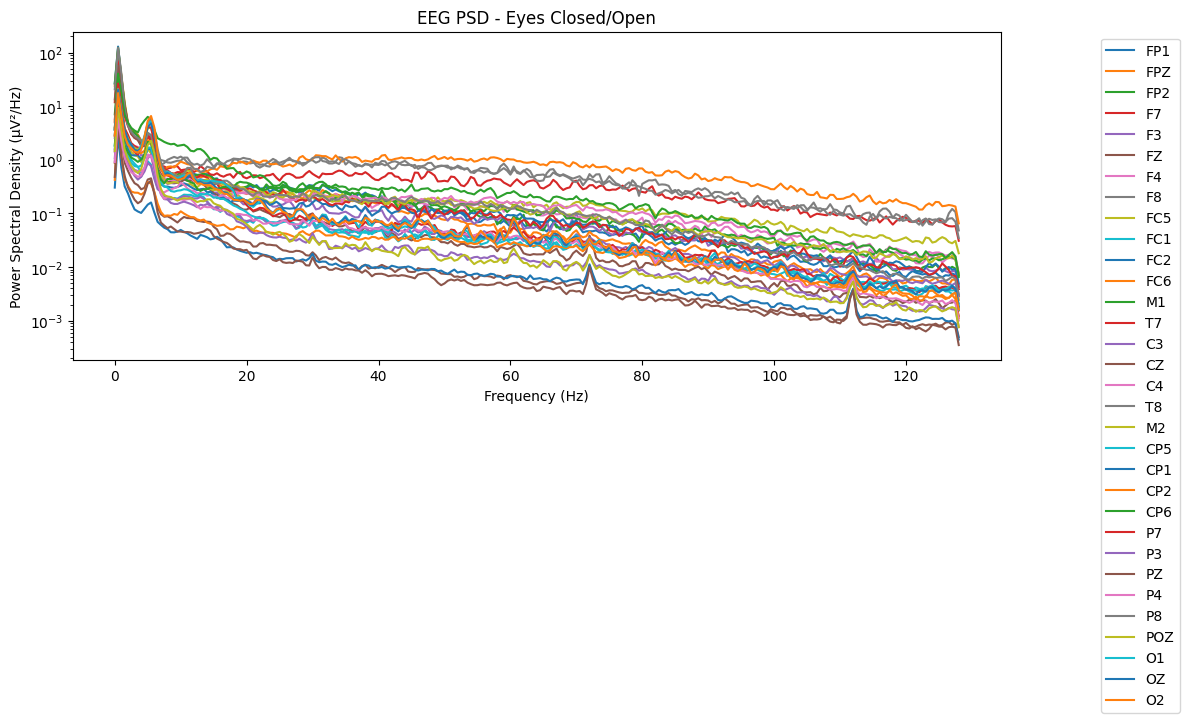

In [15]:
import numpy as np
import pyxdf
from scipy.signal import welch
import matplotlib.pyplot as plt

def load_eeg_only_xdf(filename):
    streams, _ = pyxdf.load_xdf(filename)
    eeg_stream = None

    for s in streams:
        if s['info']['type'][0].lower() == 'eeg':
            eeg_stream = s
            break

    if eeg_stream is None:
        raise ValueError("No EEG stream found in file.")

    # EEG data: [samples, channels]
    eeg_ts = np.array(eeg_stream['time_series'])
    eeg_data = eeg_ts.T  # [channels, samples]
    timestamps = np.array(eeg_stream['time_stamps'])

    # Channel labels
    try:
        channel_labels = [ch['label'][0] for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']]
    except:
        channel_labels = [f"Ch{i+1}" for i in range(eeg_data.shape[0])]

    return eeg_data, timestamps, channel_labels

def compute_psd(eeg_data, fs=256):
    freqs, psd = welch(eeg_data, fs=fs, nperseg=fs*2, axis=1)
    return freqs, psd

def plot_psd(freqs, psd, channels=None, title="EEG Power Spectral Density"):
    plt.figure(figsize=(12, 6))
    n_channels = psd.shape[0]
    for i in range(n_channels):
        label = channels[i] if channels else f"Ch {i+1}"
        plt.semilogy(freqs, psd[i], label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (µV²/Hz)")
    plt.title(title)
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

# ---------- Run this ----------
if __name__ == '__main__':
    xdf_path = "Group6/sub-P621/ses-S001ecpostACS/eeg/sub-P621_ses-S001ecpostACS_task-Default_run-001_eeg.xdf"  # Update path if needed

    eeg_data, timestamps, channel_labels = load_eeg_only_xdf(xdf_path)

    # EEG is first 32 channels, EOG is AUX 7 & AUX 8 (assumed to be last two)
    eeg_only = eeg_data[:32]
    eog = eeg_data[37:39]  # Assuming AUX 7 and AUX 8 are channels 38 and 39 (index 37, 38)

    # Plot EEG PSD
    freqs, psd = compute_psd(eeg_only)
    plot_psd(freqs, psd, channels=channel_labels[:32], title="EEG PSD - Eyes Closed/Open")


In [16]:
import os
import numpy as np
import pyxdf
import pandas as pd
from scipy.signal import welch
import matplotlib.pyplot as plt

summary = []

def analyze_file(filepath, save_plots=True, fs=256):
    try:
        streams, _ = pyxdf.load_xdf(filepath)

        if len(streams) == 1:
            stream_type = streams[0]['info']['type'][0].lower()
            if stream_type == 'eeg':
                return analyze_eeg_only(filepath, streams[0], save_plots, fs)
            else:
                return analyze_combined(filepath, streams[0], save_plots, fs)
        elif len(streams) >= 2:
            return analyze_separate(filepath, streams, save_plots, fs)
        else:
            raise ValueError("No valid stream found.")
    except Exception as e:
        return {"file": filepath, "error": str(e)}

def analyze_eeg_only(filepath, stream, save_plot, fs):
    eeg = np.array(stream['time_series']).T
    eeg = eeg[:32]  # EEG only
    freqs, psd = welch(eeg, fs=fs, nperseg=fs*2, axis=1)
    if save_plot:
        plot_psd(freqs, psd, os.path.basename(filepath) + " - EEG PSD")
    return {"file": filepath, "type": "EEG-only", "accuracy": None, "avg_rt": None}

def analyze_combined(filepath, stream, save_plot, fs):
    cells = stream['time_series']
    times = stream['time_stamps']
    eeg = np.array(cells[0]).T[:32]
    markers = np.array(cells[1]).flatten().astype(int)
    marker_times = np.array(times[1])

    freqs, psd = welch(eeg, fs=fs, nperseg=fs*2, axis=1)
    acc = compute_accuracy(markers)
    rt = compute_reaction_times(markers, marker_times)
    if save_plot:
        plot_psd(freqs, psd, os.path.basename(filepath) + " - N-back PSD")
    return {"file": filepath, "type": "N-back", "accuracy": acc, "avg_rt": np.mean(rt) if rt.size > 0 else None}

def analyze_separate(filepath, streams, save_plot, fs):
    eeg_stream = next((s for s in streams if "eeg" in s['info']['type'][0].lower()), None)
    marker_stream = next((s for s in streams if "marker" in s['info']['type'][0].lower()), None)
    if eeg_stream is None or marker_stream is None:
        raise ValueError("EEG or Marker stream missing")

    eeg = np.array(eeg_stream['time_series']).T[:32]
    markers = np.array(marker_stream['time_series']).flatten().astype(int)
    marker_times = np.array(marker_stream['time_stamps'])

    freqs, psd = welch(eeg, fs=fs, nperseg=fs*2, axis=1)
    acc = compute_accuracy(markers)
    rt = compute_reaction_times(markers, marker_times)
    if save_plot:
        plot_psd(freqs, psd, os.path.basename(filepath) + " - N-back PSD")
    return {"file": filepath, "type": "N-back", "accuracy": acc, "avg_rt": np.mean(rt) if rt.size > 0 else None}

def compute_accuracy(markers):
    correct = np.sum(markers == 1)
    incorrect = np.sum(markers == 2)
    total = correct + incorrect
    return correct / total if total > 0 else None

def compute_reaction_times(markers, times):
    rts = []
    for idx in np.where(markers == 0)[0]:
        for j in range(idx+1, len(markers)):
            if markers[j] in (100, 200):
                rts.append(times[j] - times[idx])
                break
    return np.array(rts)

def plot_psd(freqs, psd, title):
    plt.figure(figsize=(10, 5))
    for i in range(psd.shape[0]):
        plt.semilogy(freqs, psd[i])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (µV²/Hz)")
    plt.tight_layout()
    filename = title.replace(" ", "_").replace("/", "_") + ".png"
    plt.savefig(filename)
    plt.close()

# --------- RUN ON ALL XDF FILES ---------
if __name__ == '__main__':
    root_dir = "."  # or full path like "/Users/ankit/Documents/Neural Engineering/Group6"
    results = []

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".xdf"):
                path = os.path.join(root, file)
                result = analyze_file(path)
                results.append(result)
                print(f"Done: {file}")

    # Save summary
    df = pd.DataFrame(results)
    df.to_csv("xdf_analysis_summary.csv", index=False)
    print("\n✅ Analysis complete. Results saved to xdf_analysis_summary.csv")


Done: sub-P621_ses-S001ecpostn_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S001eo_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S001ecpretACS_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S001eog_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S001n_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S002r_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S002N2post_task-Default_run-004_eeg.xdf
Done: sub-P621_ses-S002N2post_task-Default_run-005_eeg.xdf
Done: sub-P621_ses-S002N2post_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S002N2post_task-Default_run-003_eeg.xdf
Done: sub-P621_ses-S002N2post_task-Default_run-002_eeg.xdf
Done: sub-P621_ses-S001N2pre_task-Default_run-004_eeg.xdf
Done: sub-P621_ses-S001N2pre_task-Default_run-005_eeg.xdf
Done: sub-P621_ses-S001N2pre_task-Default_run-003_eeg.xdf
Done: sub-P621_ses-S001N2pre_task-Default_run-002_eeg.xdf
Done: sub-P621_ses-S001N2pre_task-Default_run-001_eeg.xdf
Done: sub-P621_ses-S002ecpost_task-Default_run-001_eeg.xdf
Done: sub-P621_

In [1]:
import numpy as np
import pyxdf
from scipy.signal import welch

### ===== 1. Load Any XDF File and Identify Type ===== ###
def load_xdf_file(path):
    streams, _ = pyxdf.load_xdf(path)
    if len(streams) == 1:
        stype = streams[0]['info']['type'][0].lower()
        if stype == 'eeg':
            return "eeg_only", {"eeg": streams[0]}
        else:
            return "combined", {"stream": streams[0]}
    elif len(streams) >= 2:
        stream_map = {}
        for s in streams:
            stype = s['info']['type'][0].lower()
            if "eeg" in stype:
                stream_map['eeg'] = s
            elif "marker" in stype:
                stream_map['marker'] = s
        return "separate", stream_map
    else:
        raise ValueError("No valid stream found.")

### ===== 2. Extract EEG Data ===== ###
def extract_eeg_data(stream, only_eeg=True):
    eeg = np.array(stream['time_series']).T
    timestamps = np.array(stream['time_stamps'])
    labels = [f"Ch{i+1}" for i in range(eeg.shape[0])]
    try:
        labels = [ch['label'][0] for ch in stream['info']['desc'][0]['channels'][0]['channel']]
    except:
        pass
    return eeg[:32] if only_eeg else eeg, timestamps, labels

### ===== 3. Extract EOG Channels (usually AUX 7 & 8) ===== ###
def extract_eog_data(eeg_data):
    return eeg_data[37:39]  # typically AUX7 & AUX8

### ===== 4. Extract Marker Data ===== ###
def extract_marker_data(marker_stream):
    markers = np.array(marker_stream['time_series']).flatten().astype(int)
    times = np.array(marker_stream['time_stamps'])
    return markers, times

def extract_combined_markers(stream):
    markers = np.array(stream['time_series'][1]).flatten().astype(int)
    times = np.array(stream['time_stamps'][1])
    return markers, times

### ===== 5. Compute PSD ===== ###
def compute_psd(data, fs=256):
    freqs, psd = welch(data, fs=fs, nperseg=fs*2, axis=1)
    return freqs, psd

### ===== 6. Compute Accuracy from Markers ===== ###
def compute_accuracy(markers):
    correct = np.sum(markers == 1)
    incorrect = np.sum(markers == 2)
    total = correct + incorrect
    return correct / total if total > 0 else None

### ===== 7. Compute Reaction Times ===== ###
def compute_reaction_times(markers, times):
    rts = []
    for i in np.where(markers == 0)[0]:
        for j in range(i+1, len(markers)):
            if markers[j] in (100, 200):
                rts.append(times[j] - times[i])
                break
    return np.array(rts)

### ===== 8. Optional: Bandpower Helper ===== ###
def compute_bandpower(freqs, psd, band):
    idx = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    return np.mean(psd[:, idx], axis=1)

# Bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,12), 'beta': (13,30), 'gamma': (30,45)}


In [5]:
path = "Group6/sub-P621/ses-S001N2post/eeg/sub-P621_ses-S001N2post_task-Default_run-001_eeg.xdf"

dtype, data = load_xdf_file(path)

print(f"Data Type: {dtype}")
print(f"Data: {data}")

if dtype == "eeg_only":
    eeg, ts, labels = extract_eeg_data(data["eeg"])
    freqs, psd = compute_psd(eeg)
    
elif dtype == "combined":
    stream = data["stream"]
    eeg = np.array(stream['time_series'][0]).T[:32]
    eeg_ts = stream['time_stamps'][0]
    markers, marker_ts = extract_combined_markers(stream)
    acc = compute_accuracy(markers)
    rts = compute_reaction_times(markers, marker_ts)

elif dtype == "separate":
    eeg, ts, labels = extract_eeg_data(data["eeg"])
    markers, marker_ts = extract_marker_data(data["marker"])


Data Type: separate
Data: {'marker': {'info': defaultdict(<class 'list'>, {'name': ['MarkerStream'], 'type': ['Markers'], 'channel_count': ['2'], 'channel_format': ['float32'], 'source_id': ['marker_stream_id'], 'nominal_srate': ['0.000000000000000'], 'version': ['1.100000000000000'], 'created_at': ['161762.6467167450'], 'uid': ['fe0f7f17-cabe-4eef-9a9b-0f1e8bbec001'], 'session_id': ['default'], 'hostname': ['ecen-a52211'], 'v4address': [None], 'v4data_port': ['16572'], 'v4service_port': ['16572'], 'v6address': [None], 'v6data_port': ['16573'], 'v6service_port': ['16573'], 'desc': [None], 'stream_id': 2, 'effective_srate': 0}), 'footer': {'info': defaultdict(<class 'list'>, {'first_timestamp': ['161996.855679512'], 'last_timestamp': ['162106.716339823'], 'sample_count': ['192'], 'clock_offsets': [defaultdict(<class 'list'>, {'offset': [defaultdict(<class 'list'>, {'time': ['161975.6619181865'], 'value': ['-3.055849811062217e-05']}), defaultdict(<class 'list'>, {'time': ['161980.6619904

In [13]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
import pyxdf

# Re-defining essential xdf_utils functionality
def load_xdf_file(path):
    streams, _ = pyxdf.load_xdf(path)
    if len(streams) == 1:
        stype = streams[0]['info']['type'][0].lower()
        if stype == 'eeg':
            return "eeg_only", {"eeg": streams[0]}
        else:
            return "combined", {"stream": streams[0]}
    elif len(streams) >= 2:
        stream_map = {}
        for s in streams:
            stype = s['info']['type'][0].lower()
            if "eeg" in stype:
                stream_map['eeg'] = s
            elif "marker" in stype:
                stream_map['marker'] = s
        return "separate", stream_map
    else:
        raise ValueError("No valid stream found.")

def extract_eeg_data(stream, only_eeg=True):
    eeg = np.array(stream['time_series']).T
    timestamps = np.array(stream['time_stamps'])
    labels = [f"Ch{i+1}" for i in range(eeg.shape[0])]
    try:
        labels = [ch['label'][0] for ch in stream['info']['desc'][0]['channels'][0]['channel']]
    except:
        pass
    return eeg[:32] if only_eeg else eeg, timestamps, labels

def extract_combined_markers(stream):
    markers = np.array(stream['time_series'][1]).flatten().astype(int)
    times = np.array(stream['time_stamps'][1])
    return markers, times

def compute_psd(data, fs=256):
    freqs, psd = welch(data, fs=fs, nperseg=fs*2, axis=1)
    return freqs, psd

# def compute_accuracy(markers):
#     correct = np.sum(markers == 1)
#     incorrect = np.sum(markers == 2)
#     total = correct + incorrect
#     return correct / total if total > 0 else None

def compute_accuracy(markers):
    # More realistic: out of all trials (match/non-match), how many were correct
    total_trials = np.sum(np.isin(markers, [11, 12]))
    correct = np.sum(markers == 1)
    return correct / total_trials if total_trials > 0 else None

# def compute_reaction_times(markers, times):
#     rts = []
#     for i in np.where(markers == 0)[0]:
#         for j in range(i+1, len(markers)):
#             if markers[j] in (100, 200):
#                 rts.append(times[j] - times[i])
#                 break
#     return np.array(rts)

def compute_reaction_times(markers, times):
    rts = []
    if len(markers) != len(times):
        print("Warning: markers and times are mismatched in length.")
        min_len = min(len(markers), len(times))
        markers = markers[:min_len]
        times = times[:min_len]

    trial_starts = np.where(markers == 0)[0]
    for i in trial_starts:
        for j in range(i+1, len(markers)):
            if markers[j] in (100, 200):
                if j < len(times) and i < len(times):
                    rts.append(times[j] - times[i])
                break
    return np.array(rts)

def compute_bandpower(freqs, psd, band):
    idx = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    return np.mean(psd[:, idx], axis=1)



# Config
band_ranges = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30),
    "gamma": (30, 45),
}

session_map = {
    "N2pre": "nback_pre",
    "N2post": "nback_post",
    "ecpre": "eeg_pre",
    "ecpost": "eeg_post"
}

base_dir = "Group6"
behavioral_results = []
eeg_results = []

# Traverse subjects
for subject in os.listdir(base_dir):
    subj_path = os.path.join(base_dir, subject)
    if not os.path.isdir(subj_path): continue

    file_dict = {}
    for root, _, files in os.walk(subj_path):
        for f in files:
            if f.endswith(".xdf"):
                for tag, label in session_map.items():
                    if tag in f:
                        file_dict[label] = os.path.join(root, f)

    if "nback_pre" in file_dict and "nback_post" in file_dict:
            try:
                # Load both files
                pre_type, pre_data = load_xdf_file(file_dict["nback_pre"])
                post_type, post_data = load_xdf_file(file_dict["nback_post"])

                # Extract markers depending on stream type
                if pre_type == "combined":
                    pre_markers, pre_times = extract_combined_markers(pre_data["stream"])
                elif pre_type == "separate":
                    pre_markers = np.array(pre_data["marker"]['time_series']).flatten().astype(int)
                    pre_times = np.array(pre_data["marker"]['time_stamps'])

                if post_type == "combined":
                    post_markers, post_times = extract_combined_markers(post_data["stream"])
                elif post_type == "separate":
                    post_markers = np.array(post_data["marker"]['time_series']).flatten().astype(int)
                    post_times = np.array(post_data["marker"]['time_stamps'])

                # Compute accuracy and reaction times
                pre_acc = compute_accuracy(pre_markers)
                post_acc = compute_accuracy(post_markers)
                pre_rt = np.mean(compute_reaction_times(pre_markers, pre_times))
                post_rt = np.mean(compute_reaction_times(post_markers, post_times))

                behavioral_results.append({
                    "subject": subject,
                    "pre_accuracy": pre_acc,
                    "post_accuracy": post_acc,
                    "accuracy_change": post_acc - pre_acc,
                    "pre_avg_rt": pre_rt,
                    "post_avg_rt": post_rt,
                    "rt_change": post_rt - pre_rt
                })

            except Exception as e:
                print(f"Behavioral analysis failed for {subject}: {e}")

    if "eeg_pre" in file_dict and "eeg_post" in file_dict:
        try:
            _, pre_data = load_xdf_file(file_dict["eeg_pre"])
            _, post_data = load_xdf_file(file_dict["eeg_post"])
            pre_eeg, _, _ = extract_eeg_data(pre_data["eeg"])
            post_eeg, _, _ = extract_eeg_data(post_data["eeg"])

            freqs_pre, psd_pre = compute_psd(pre_eeg)
            freqs_post, psd_post = compute_psd(post_eeg)

            row = {"subject": subject}
            for band, bounds in band_ranges.items():
                band_pre = np.mean(compute_bandpower(freqs_pre, psd_pre, bounds))
                band_post = np.mean(compute_bandpower(freqs_post, psd_post, bounds))
                row[f"{band}_pre"] = band_pre
                row[f"{band}_post"] = band_post
                row[f"{band}_delta"] = band_post - band_pre
            eeg_results.append(row)
        except Exception as e:
            print(f"EEG analysis failed for {subject}: {e}")

# Save and display results
behav_df = pd.DataFrame(behavioral_results)
eeg_df = pd.DataFrame(eeg_results)

behav_df.to_csv("behavioral_summary.csv", index=False)
eeg_df.to_csv("eeg_band_summary.csv", index=False)

print(behav_df.head())  # or behav_df.to_csv(...)
print(eeg_df.head())


    subject  pre_accuracy  post_accuracy  accuracy_change  pre_avg_rt  \
0  sub-P621      0.820513       0.846154         0.025641    2.025155   
1  sub-P622      0.923077       0.871795        -0.051282    1.449854   
2  sub-P623      0.743590       0.769231         0.025641    1.495092   

   post_avg_rt  rt_change  
0     2.015639  -0.009516  
1     2.281830   0.831976  
2     0.978148  -0.516944  
    subject  delta_pre  delta_post  delta_delta  theta_pre  theta_post  \
0  sub-P621   3.324066    3.281252    -0.042814   1.764008    1.275317   
1  sub-P622  18.605093   20.513838     1.908745   9.461491   10.393676   
2  sub-P623  27.318711    7.639223   -19.679488  10.341456    7.975121   

   theta_delta  alpha_pre  alpha_post  alpha_delta  beta_pre  beta_post  \
0    -0.488691   0.465156    0.455174    -0.009982  0.204217   0.263671   
1     0.932185   0.700513    0.840145     0.139632  0.232171   0.388136   
2    -2.366335   0.985052    0.475506    -0.509547  0.685089   0.150734  

In [14]:
import os
import numpy as np
import pandas as pd
import pyxdf

# --- Utilities from before ---
def load_xdf_file(path):
    streams, _ = pyxdf.load_xdf(path)
    if len(streams) == 1:
        stype = streams[0]['info']['type'][0].lower()
        if stype == 'eeg':
            return "eeg_only", {"eeg": streams[0]}
        else:
            return "combined", {"stream": streams[0]}
    elif len(streams) >= 2:
        stream_map = {}
        for s in streams:
            stype = s['info']['type'][0].lower()
            if "eeg" in stype:
                stream_map['eeg'] = s
            elif "marker" in stype:
                stream_map['marker'] = s
        return "separate", stream_map
    else:
        raise ValueError("No valid stream found.")

def extract_combined_markers(stream):
    markers = np.array(stream['time_series'][1]).flatten().astype(int)
    times = np.array(stream['time_stamps'][1])
    return markers, times

def compute_accuracy(markers):
    total_trials = np.sum(np.isin(markers, [11, 12]))
    correct = np.sum(markers == 1)
    return correct / total_trials if total_trials > 0 else None

def compute_reaction_times(markers, times):
    rts = []
    if len(markers) != len(times):
        min_len = min(len(markers), len(times))
        markers = markers[:min_len]
        times = times[:min_len]

    for i in np.where(markers == 0)[0]:
        for j in range(i+1, len(markers)):
            if markers[j] in (100, 200):
                if j < len(times) and i < len(times):
                    rts.append(times[j] - times[i])
                break
    return np.array(rts)

# --- Subject condition map ---
subject_order = {
    "sub-P621": {"day1": "tES", "day2": "Relaxation"},
    "sub-P622": {"day1": "Relaxation", "day2": "tES"},
    "sub-P623": {"day1": "Relaxation", "day2": "tES"},
}

# --- Main Analysis ---
base_dir = "./Group6"  # adjust this if needed
behavioral_results = []

for subject in os.listdir(base_dir):
    subj_path = os.path.join(base_dir, subject)
    if not os.path.isdir(subj_path): continue

    print(f"Processing {subject}...")

    for day in [1, 2]:  # session 1 and 2
        session_tag = f"S00{day}N2"

        pre_file = None
        post_file = None

        # Find pre and post N-back files
        for root, _, files in os.walk(subj_path):
            for f in files:
                if f.endswith(".xdf"):
                    if session_tag + "pre" in f:
                        pre_file = os.path.join(root, f)
                    elif session_tag + "post" in f:
                        post_file = os.path.join(root, f)

        if pre_file and post_file:
            try:
                pre_type, pre_data = load_xdf_file(pre_file)
                post_type, post_data = load_xdf_file(post_file)

                # extract markers
                if pre_type == "combined":
                    pre_markers, pre_times = extract_combined_markers(pre_data["stream"])
                else:
                    pre_markers = np.array(pre_data["marker"]['time_series']).flatten().astype(int)
                    pre_times = np.array(pre_data["marker"]['time_stamps'])

                if post_type == "combined":
                    post_markers, post_times = extract_combined_markers(post_data["stream"])
                else:
                    post_markers = np.array(post_data["marker"]['time_series']).flatten().astype(int)
                    post_times = np.array(post_data["marker"]['time_stamps'])

                # compute metrics
                pre_acc = compute_accuracy(pre_markers)
                post_acc = compute_accuracy(post_markers)
                pre_rt = np.mean(compute_reaction_times(pre_markers, pre_times))
                post_rt = np.mean(compute_reaction_times(post_markers, post_times))

                condition = subject_order[subject]["day1"] if day == 1 else subject_order[subject]["day2"]

                behavioral_results.append({
                    "subject": subject,
                    "condition": condition,
                    "pre_accuracy": pre_acc,
                    "post_accuracy": post_acc,
                    "accuracy_change": post_acc - pre_acc,
                    "pre_avg_rt": pre_rt,
                    "post_avg_rt": post_rt,
                    "rt_change": post_rt - pre_rt
                })

            except Exception as e:
                print(f"Failed for {subject} Day {day}: {e}")

# Save results
behavioral_df = pd.DataFrame(behavioral_results)
behavioral_df.to_csv("behavioral_summary_split_conditions.csv", index=False)

print("\n✅ Behavioral Analysis Completed. Results saved to behavioral_summary_split_conditions.csv")
print(behavioral_df)


Processing sub-P621...
Processing sub-P622...
Processing sub-P623...

✅ Behavioral Analysis Completed. Results saved to behavioral_summary_split_conditions.csv
    subject   condition  pre_accuracy  post_accuracy  accuracy_change  \
0  sub-P621         tES      0.794872       0.846154         0.051282   
1  sub-P621  Relaxation      0.820513       0.871795         0.051282   
2  sub-P622         tES      0.923077       0.871795        -0.051282   
3  sub-P623  Relaxation      0.769231       0.769231         0.000000   
4  sub-P623         tES      0.743590       0.692308        -0.051282   

   pre_avg_rt  post_avg_rt  rt_change  
0    1.703360     2.015639   0.312279  
1    2.025155     2.018626  -0.006530  
2    1.449854     2.281830   0.831976  
3    1.405441     0.978148  -0.427294  
4    1.495092     1.508821   0.013729  


In [23]:
import os

# Base folder containing subject folders
base_dir = "./Group6"  # <-- change if needed

# Sessions we expect
sessions = {
    1: "S001N2",  # Day 1 session
    2: "S002N2",  # Day 2 session
}

# Track missing
missing_files = []

# Traverse subjects
for subject in os.listdir(base_dir):
    subj_path = os.path.join(base_dir, subject)
    if not os.path.isdir(subj_path):
        continue

    print(f"\n📂 Checking subject: {subject}")

    for day in [1, 2]:
        session_tag = sessions[day]
        pre_found = False
        post_found = False

        for root, _, files in os.walk(subj_path):
            for f in files:
                if f.endswith(".xdf"):
                    if session_tag + "pre" in f:
                        pre_found = True
                    elif session_tag + "post" in f:
                        post_found = True

        # Print what was found
        status = []
        if pre_found:
            status.append("✅ Pre")
        else:
            status.append("❌ Pre missing")
            missing_files.append((subject, f"Day {day} Pre"))

        if post_found:
            status.append("✅ Post")
        else:
            status.append("❌ Post missing")
            missing_files.append((subject, f"Day {day} Post"))

        print(f"  Day {day} session: {' | '.join(status)}")

# Summary
print("\nSummary of missing files:")
for subject, session in missing_files:
    print(f"  ❌ {subject} - {session}")



📂 Checking subject: sub-P621
  Day 1 session: ✅ Pre | ✅ Post
  Day 2 session: ✅ Pre | ✅ Post

📂 Checking subject: sub-P622
  Day 1 session: ❌ Pre missing | ❌ Post missing
  Day 2 session: ✅ Pre | ✅ Post

📂 Checking subject: sub-P623
  Day 1 session: ✅ Pre | ✅ Post
  Day 2 session: ✅ Pre | ✅ Post

Summary of missing files:
  ❌ sub-P622 - Day 1 Pre
  ❌ sub-P622 - Day 1 Post
